In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup
import midi
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init()

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 10.0 0.5
 >> Context(max_t=2.0, dt=0.05, n_timesteps=40, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  40.000000
 max_f: 10.000000, min_f: 0.500000


In [5]:
n = 10 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.MIDIFILE # GLOBAL
dn = 'drum_midi/'
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, dirname=dn, multiTrack=multiTrack, r=True)


Importing midi-data

Encoding midi-data
 10
> -> multi-track = True MidiFile
 [INFO] : 
 |  True


In [6]:
# n = 1000
# min_f = 0
# max_f = 3
# x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
#     n_polyrythms=1,
#     n_channels=3,
#     d_phase=True,
#     return_params=True,
#     dim4=dim4,
#     multiTrack=multiTrack)

In [7]:
x_train.shape

(10, 40, 10, 1)

In [8]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((10, 40, 10, 1), 9)

In [9]:
x_test = x_train[m:]
x_train = x_train[:m]

m (40, 10)


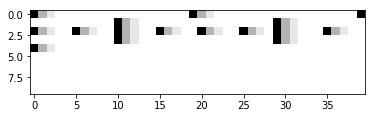

m (40, 10)


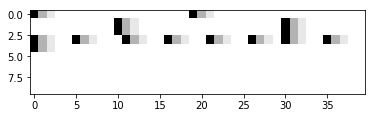

["../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"]

In [10]:
plot.single(x_train[0, :50,:,0])
plot.single(x_train[1, :50,:,0])
# plot.single(x_train[2, :50,:,0])
labels[0:4]

In [11]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(40, 10, 1)

In [12]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [13]:
def encoder(input_shape, dropout=0.1):
    encoder_input = Input(shape=input_shape)
    nodes = np.prod(input_shape)

    # Convolution
    h = encoder_input
    h = Reshape(input_shape[:-1])(h)
    h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
    h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='valid')(h)
    h = Conv1D(128, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
#     h = Dropout(dropout)(h) # uncomment when using larger batches

    # RNN
    shape = K.int_shape(h)[1:]
    h = SimpleRNN(128)(h)

    h = Reshape((128, 1))(h)
    n_capsules = 10
    capsule_dim = 6
    n_routings=3
    share_weights=True
    h = Capsule(n_capsules, capsule_dim, n_routings, share_weights)(h)   
    
    # Dense layers
    h = Flatten()(h)
#     h = Dense(intermediate_dim, activation='relu')(h)
   
    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
        
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, encoder_input, z_mean, z_log_var

In [14]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

shared weights, shape = (1, 1, 60) 60
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 10, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 40, 10)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 39, 32)       672         reshape_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 19, 64)       4160        conv1d_1[0][0]                   
_______________________________________________________________________

In [15]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [16]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)
# z_output = Lambda(sampl_, output_shape=(latent_dim,))(encoder_input)

In [17]:
def list_decoders(output_shape, p='same'):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_shape
    time_ = int(timesteps/10)
    notes_ = notes * 10
    intermediate_dim = time_ * notes_ * channels
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    output_shape = (timesteps, notes, channels)
    nodes = np.prod(output_shape)
    
    decoders = []
    decoders += [ Dense(256, activation='relu') ]
    decoders += [ Dense(256, activation='relu') ]
        
    # RNN
    dim1, dim2 = 8, 32 # 8*32=256
    # decoders += [ Reshape((dim1, dim2)) ]
    # decoders += [ SimpleRNN(128, return_sequences='True') ]
    
    branch1 = []
    branch1 += [ Dense(dim2, activation='relu') ] # constant value, a note-column for every timestep
    branch1 += [ RepeatVector(dim1) ] 
    
    branch2 = []
    branch2 += [ Dense(dim1 * dim2, activation='relu') ]
    branch2 += [ Reshape([dim1, dim2]) ]
    
    branch1_ = lambda layer: utils.composition(branch1, layer)
    branch2_ = lambda layer: utils.composition(branch2, layer)
    decoders += [ lambda layer: Add()([branch1_(layer), branch2_(layer)]) ]
    
    decoders += [ SimpleRNN(128, return_sequences='True') ]
    # rnn = SimpleRNN(dims, activation='sawDescending', return_sequences=True)
    
    #TODO     LocallyConnected2D, TimeDistributed(transposed(x))
    # TODO 2nd RNN to generate the 'repeating' state (aka decay matrix)
    decoders += [ Flatten() ]
    decoders += [ Dense(nodes, activation='relu') ]
    decoders += [ Dense(nodes, activation='relu') ]
#     decoders += [ Dropout(0.05) ]

#     # Convolution
#     # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
#     k = (2,1) # (2,1) :: (timesteps, notes)
#     s = (3,1)

#     decoders += [ Reshape((time_, notes_, channels)) ]
#     decoders += [ Conv2DTranspose(128, kernel_size=2, strides=3, activation='relu', padding=p) ]
    
#     # 'end' of upsampling
#     decoders += [ Conv2D(32, kernel_size=(1,2), strides=(1,3), activation='relu', padding=p) ]

    output_shape = (timesteps, notes, channels)
    
# #     decoders += [ Flatten()]
#     decoders += [ Dense(np.prod(output_shape), activation='relu')]
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid')]
    decoders += [ Reshape(output_shape)]
    return decoders

In [18]:
decoders = list_decoders(input_shape)

In [19]:
decoded = utils.composition(decoders, z_output, verbose=False)

In [20]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 10, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 54544       input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          768         lambda_2[0][0]                   
__________

In [21]:
# Compute VAE loss
def vae_loss(beta=1.):
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + beta * kl_loss)
    return vae_loss

vae_loss = vae_loss(beta=1)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Output "reshape_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_4" during training.
  # This is added back by InteractiveShellApp.init_path()


In [22]:
batch_size = 250
epochs = 1000
params = {'batch_size': batch_size, 'return_y': False}

In [23]:
phase_mod = 0.01
whitening = False

In [24]:
m = 2
useDataGenerator = False
useDataGenerator = True

x = x_train
x = np.concatenate([x_train[:m] for _ in range(1000)])

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x[:m], x[:m], batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x_ = x_batch
            # x_ = datagen.shuffle_3rd_dim(x_)
            x_ = datagen.shuffle_3rd_dim_soft(x_, mutation_rate=0.5, scale=0.1, verbose=0)
            h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
            for k,v in h.history.items(): 
                print(' \\_%s' % k, [round(v_,) for v_ in v])
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x[:m], epochs=epochs, validation_data=(x_test, None))
    history = h.history

batch_size = 250

[Epoch 0/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [269.0]
 \_loss [277.0]

[Epoch 1/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [123.0]
 \_loss [238.0]

[Epoch 2/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [73.0]
 \_loss [129.0]

[Epoch 3/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [75.0]
 \_loss [76.0]

[Epoch 4/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [65.0]
 \_loss [90.0]

[Epoch 5/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [69.0]
 \_loss [66.0]

[Epoch 6/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [65.0]
 \_loss [69.0]

[Epoch 7/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [58.0]
 \_loss [68.0]

[Epoch 8/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [57.0]
 \_loss [75.0]

[Epoch 9/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [68.0]
 \_loss [46.0]

[Epoch 10/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [64.0]
 \_loss [54.0]

[Epoch 11/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [58.0]
 \_loss [97.0]

[Epoch 12/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [61.0]
 \_loss [64.0]

[Epoch 13/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [6

 \_val_loss [52.0]
 \_loss [56.0]

[Epoch 116/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [61.0]
 \_loss [70.0]

[Epoch 117/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [75.0]

[Epoch 118/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [48.0]
 \_loss [48.0]

[Epoch 119/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [62.0]
 \_loss [97.0]

[Epoch 120/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [69.0]

[Epoch 121/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [50.0]
 \_loss [62.0]

[Epoch 122/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [64.0]
 \_loss [87.0]

[Epoch 123/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [49.0]
 \_loss [69.0]

[Epoch 124/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [49.0]
 \_loss [45.0]

[Epoch 125/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [50.0]
 \_loss [84.0]

[Epoch 126/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [50.0]
 \_loss [64.0]

[Epoch 127/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [50.0]
 \_loss [51.0]

[Epoch 128/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [53.0]
 \_loss [40.0]

[Epoch 129/1000]

 Batch 0/0
 \_val_loss [47.0]
 \_loss [56.0]

[Epoch 235/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [48.0]
 \_loss [51.0]

[Epoch 236/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [48.0]
 \_loss [45.0]

[Epoch 237/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [49.0]
 \_loss [46.0]

[Epoch 238/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [50.0]
 \_loss [62.0]

[Epoch 239/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [61.0]

[Epoch 240/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [46.0]

[Epoch 241/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [51.0]
 \_loss [61.0]

[Epoch 242/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [58.0]

[Epoch 243/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [54.0]
 \_loss [72.0]

[Epoch 244/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [66.0]

[Epoch 245/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [50.0]

[Epoch 246/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [48.0]
 \_loss [62.0]

[Epoch 247/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [53.0]
 \_loss [71.0]

[Epoc

 \_val_loss [45.0]
 \_loss [78.0]

[Epoch 349/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [48.0]
 \_loss [63.0]

[Epoch 350/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [48.0]
 \_loss [64.0]

[Epoch 351/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [51.0]
 \_loss [72.0]

[Epoch 352/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [44.0]
 \_loss [67.0]

[Epoch 353/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [55.0]

[Epoch 354/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [56.0]

[Epoch 355/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [57.0]
 \_loss [89.0]

[Epoch 356/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [62.0]

[Epoch 357/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [62.0]

[Epoch 358/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [60.0]

[Epoch 359/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [44.0]
 \_loss [63.0]

[Epoch 360/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [48.0]
 \_loss [65.0]

[Epoch 361/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [44.0]
 \_loss [55.0]

[Epoch 362/1000]

 \_val_loss [45.0]
 \_loss [54.0]

[Epoch 464/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [51.0]

[Epoch 465/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [48.0]

[Epoch 466/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [61.0]

[Epoch 467/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [53.0]

[Epoch 468/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [56.0]

[Epoch 469/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [50.0]
 \_loss [85.0]

[Epoch 470/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [67.0]

[Epoch 471/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [56.0]

[Epoch 472/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [51.0]

[Epoch 473/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [44.0]
 \_loss [47.0]

[Epoch 474/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [45.0]

[Epoch 475/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [63.0]

[Epoch 476/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [57.0]

[Epoch 477/1000]

 \_val_loss [46.0]
 \_loss [47.0]

[Epoch 583/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [53.0]

[Epoch 584/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [57.0]

[Epoch 585/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [54.0]

[Epoch 586/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [41.0]

[Epoch 587/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [49.0]
 \_loss [74.0]

[Epoch 588/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [65.0]

[Epoch 589/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [62.0]

[Epoch 590/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [60.0]

[Epoch 591/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [56.0]

[Epoch 592/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [54.0]

[Epoch 593/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [53.0]

[Epoch 594/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [55.0]

[Epoch 595/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [53.0]

[Epoch 596/1000]

 \_val_loss [45.0]
 \_loss [53.0]

[Epoch 705/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [59.0]

[Epoch 706/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [59.0]

[Epoch 707/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [54.0]

[Epoch 708/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [60.0]

[Epoch 709/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [61.0]

[Epoch 710/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [55.0]

[Epoch 711/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [48.0]

[Epoch 712/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [48.0]
 \_loss [60.0]

[Epoch 713/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [61.0]

[Epoch 714/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [49.0]

[Epoch 715/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [49.0]
 \_loss [72.0]

[Epoch 716/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [56.0]

[Epoch 717/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [55.0]

[Epoch 718/1000]

 \_val_loss [45.0]
 \_loss [51.0]

[Epoch 820/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [59.0]

[Epoch 821/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [58.0]

[Epoch 822/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [56.0]

[Epoch 823/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [48.0]
 \_loss [68.0]

[Epoch 824/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [59.0]

[Epoch 825/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [51.0]

[Epoch 826/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [48.0]
 \_loss [66.0]

[Epoch 827/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [50.0]

[Epoch 828/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [57.0]

[Epoch 829/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [52.0]

[Epoch 830/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [55.0]

[Epoch 831/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [64.0]

[Epoch 832/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [64.0]

[Epoch 833/1000]

 Batch 0/0
 \_val_loss [47.0]
 \_loss [66.0]

[Epoch 939/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [54.0]

[Epoch 940/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [47.0]

[Epoch 941/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [52.0]

[Epoch 942/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [60.0]

[Epoch 943/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [47.0]
 \_loss [62.0]

[Epoch 944/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [49.0]
 \_loss [70.0]

[Epoch 945/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [48.0]
 \_loss [69.0]

[Epoch 946/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [48.0]
 \_loss [68.0]

[Epoch 947/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [54.0]
 \_loss [82.0]

[Epoch 948/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [59.0]

[Epoch 949/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [51.0]

[Epoch 950/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [46.0]
 \_loss [50.0]

[Epoch 951/1000] >>>>>>>>>
 Batch 0/0
 \_val_loss [45.0]
 \_loss [51.0]

[Epoc

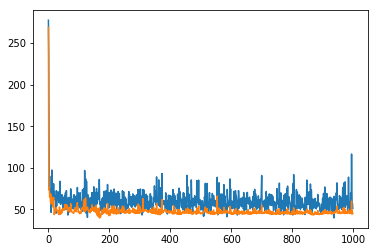

In [25]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

m (40, 10)


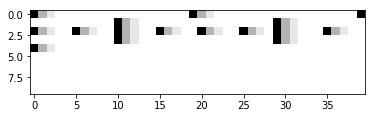

m (40, 10)


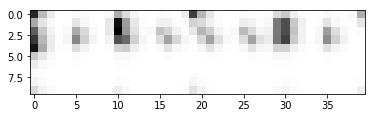

m (40, 10)


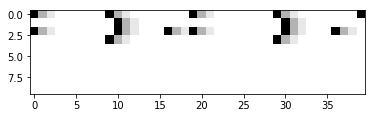

m (40, 10)


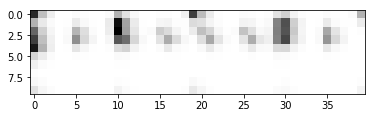

m (40, 10)


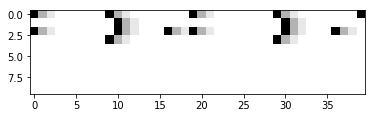

m (40, 10)


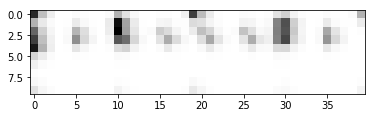

In [26]:
i = 0
j = -1
k = -1
x = vae.predict(x_train[:100])
plot.single(x_train[i, :50, :, 0])
plot.single(x[i, :50, :, 0])
plot.single(x_train[j, :50, :, 0])
plot.single(x[j, :50, :, 0])
plot.single(x_train[k, :50, :, 0])
plot.single(x[k, :50, :, 0])

m (40, 10)


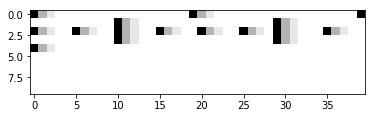

m (40, 10)


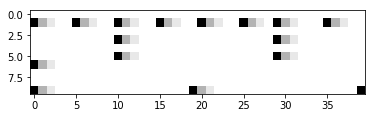

m (40, 10)


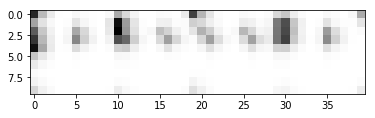

In [27]:
x = datagen.shuffle_3rd_dim_soft(x_train[:10], mutation_rate=0.5, scale=0.5, verbose=0)
plot.single(x_train[0,:,:,0])
plot.single(x[0,:,:,0])
x_ = vae.predict(x)
plot.single(x_[0,:,:,0])

In [28]:
x.shape

(9, 40, 10, 1)

m (30, 10)


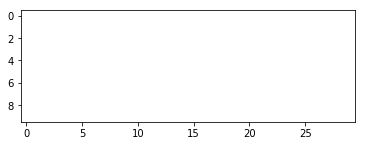

In [29]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

m (30, 10)


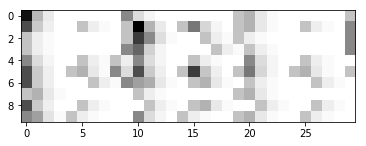

In [30]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Generator
A model to project inputs on the latent space

In [31]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [32]:
x_test.shape

(1, 40, 10, 1)

In [33]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(9, 2)

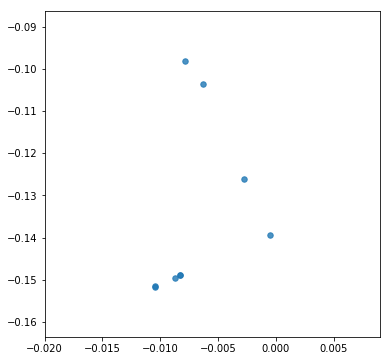

In [34]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.8, s=30) # c=y_test, 

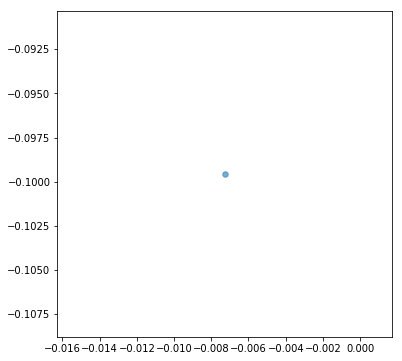

In [35]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.6, s=30) # , c=y_test
# plt.colorbar()

In [36]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [79]:
# x_decoded[0].reshape(150,3)

In [80]:
x_train.shape

(9, 40, 10, 1)

(2,) [0. 0.]


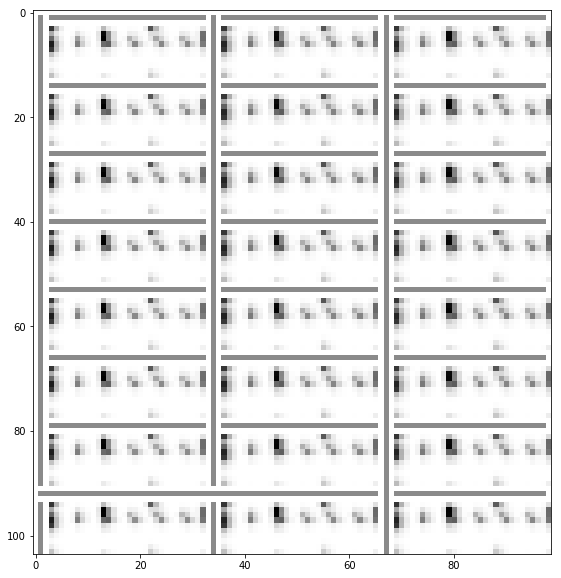

In [81]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

(2,) [0. 0.]


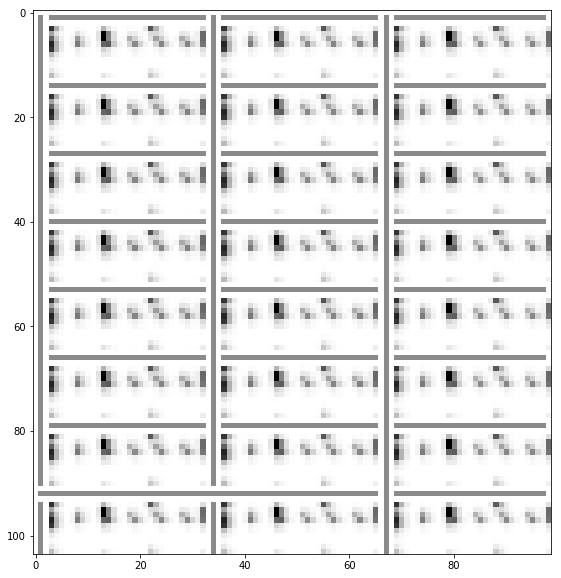

In [82]:
min_y2 = max_y
plot.latent(generator, batch_size,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)